<a href="https://colab.research.google.com/github/topkek777/digital-image-processing/blob/master/lr1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from math import *

## 1.Гистограммы. Выбрать произвольное слабоконтрастное изображение. Выполнить выравнивание гистограммы и растяжение контраста. Сравнить полученные результаты

In [57]:
# Cчитываем изображение
image = cv2.imread("/content/drive/MyDrive/lr1/lr1_1.jpg")

In [58]:
# Разрешение 981 на 736 пикселей и 3 канала BGR
print(np.min(image), np.max(image))
print(image.shape)

0 255
(981, 736, 3)


In [59]:
# По определению, гистограмма - распределение частоты встречаемости пикселей одинаковой яркости на изображении.
def calc_hist(image, maximum_intensity=256):
    hist = []
    for i in range(image.shape[2]):
        hist.append([0 for j in range(maximum_intensity)])
    hist = np.array(hist)
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                hist[i][image[y][x][i]] += 1
    return hist

my_hist = calc_hist(image)

0 0
0 0
0 0


<ipython-input-60-763f5c447ab6>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hist_cv2 = np.array([hist_cv2[i][0] for i in range(256)], dtype=np.int)


(0.0, 256.0)

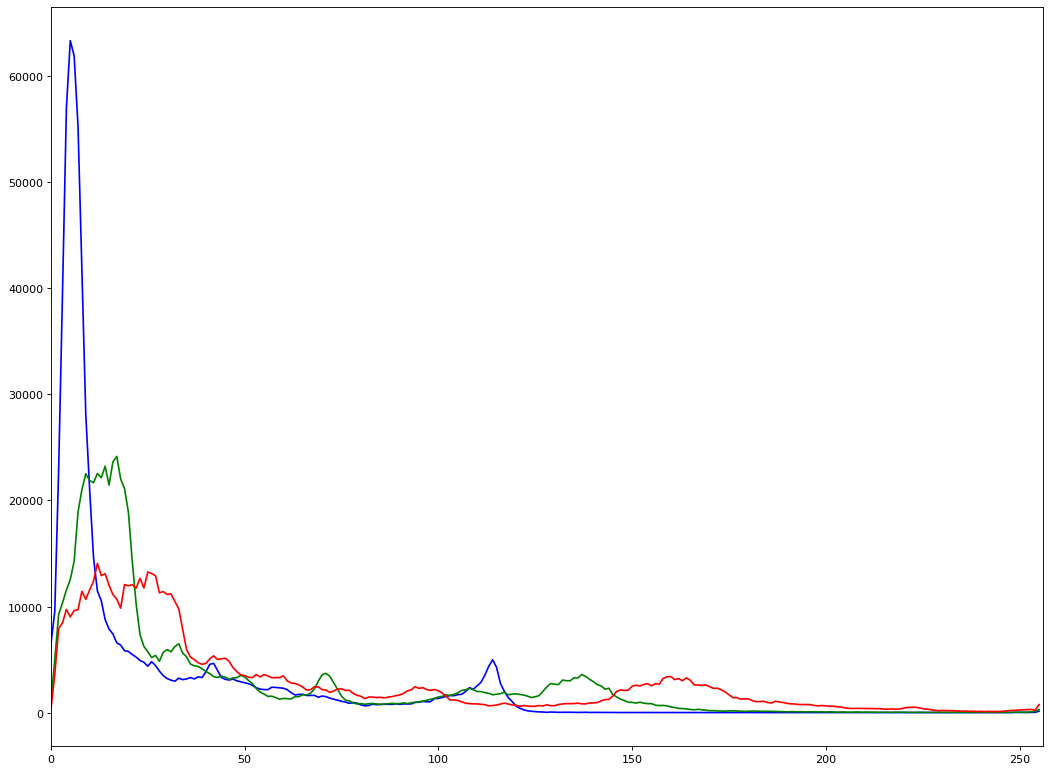

In [60]:
# Выведем рассчитанную гистограмму
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    hist_cv2 = cv2.calcHist([image],[i],None,[256],[0,256])
    hist_cv2 = np.array([hist_cv2[i][0] for i in range(256)], dtype=np.int)
    diff = my_hist[i] - hist_cv2
    print(np.min(diff), np.max(diff))
    plt.plot(my_hist[i], color = col)
plt.xlim([0,256])

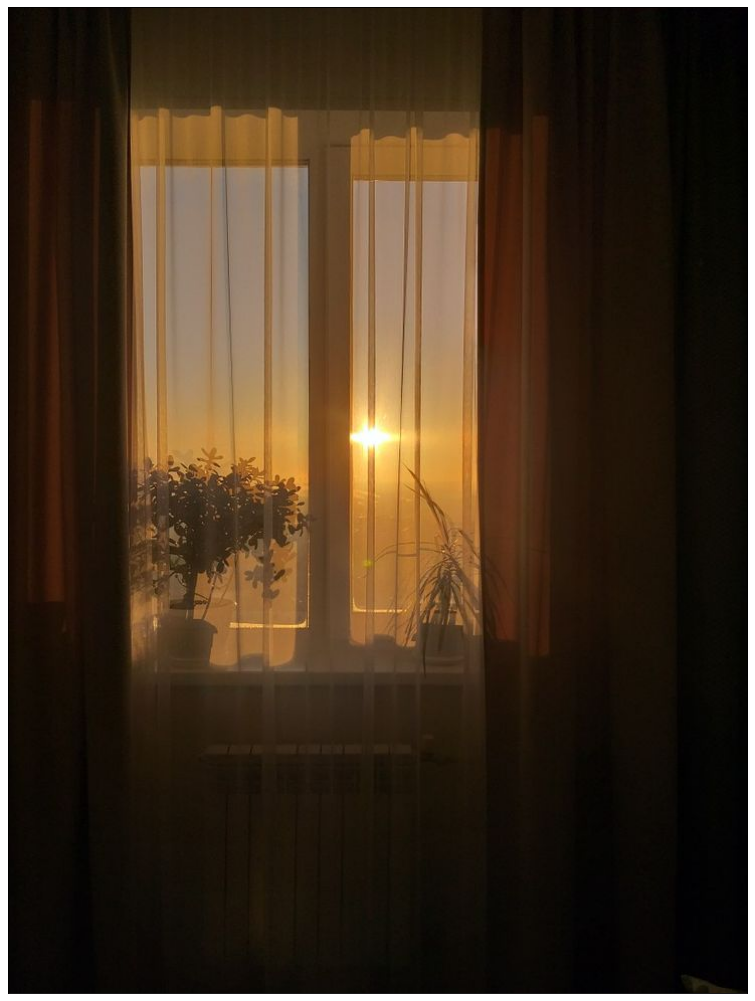

In [61]:
# Исходное изображение
# Как видно из гистограммы, присутствует много тёмных пиков
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

## Выравнивание гистограммы

Простейшими способами выравнивания гистограммы являются арифметические операции с изображениями. Например, в случае если большинство значений гистограммы находятся слева, то изображение является темным. Для увеличения детализации темных областей можно сдвинуть гистограмму правее, в более светлую область.

In [ ]:
linear_bias = 40 # Величина линейного сдвига интенсивностей
image_linear_bias = np.clip(image + linear_bias, 0, 255) # Ограничие полученной интенсивности снизу 0 и сверху 255
hist_linear_bias = calc_hist(image_linear_bias)

(0.0, 256.0)

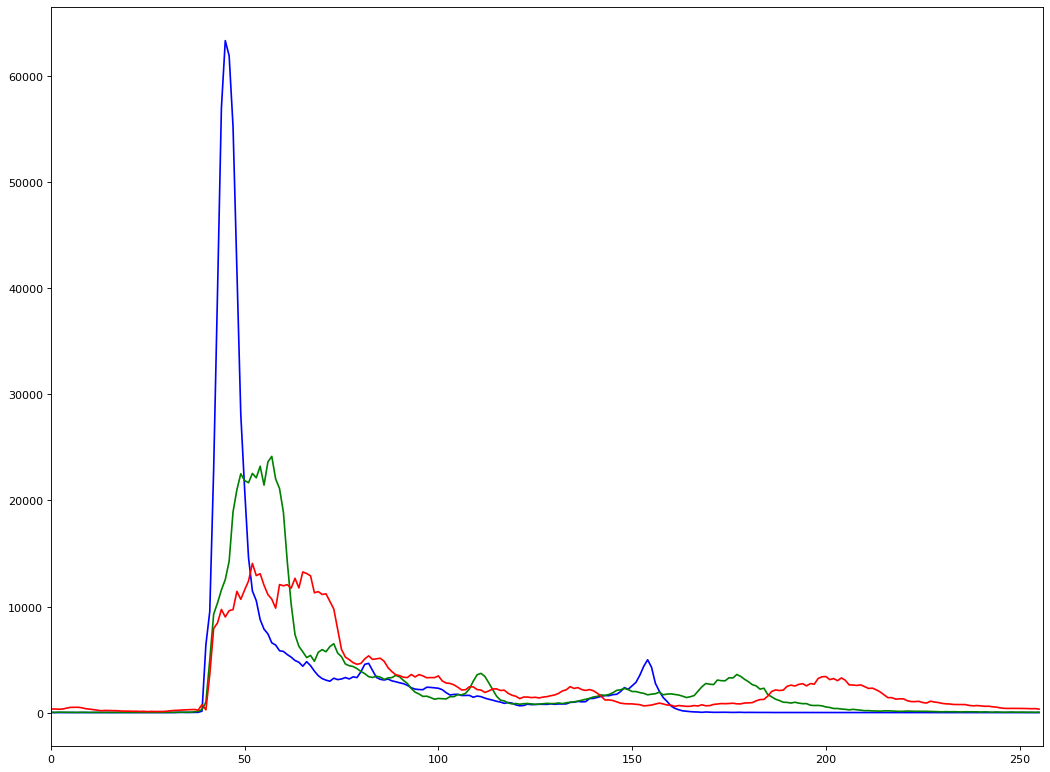

In [ ]:
# Гистограмма после линейного сдвина
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    plt.plot(hist_linear_bias[i], color = col)
plt.xlim([0,256])

In [ ]:
# Изображение после линейного сдвига интенсивностей
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image_linear_bias, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

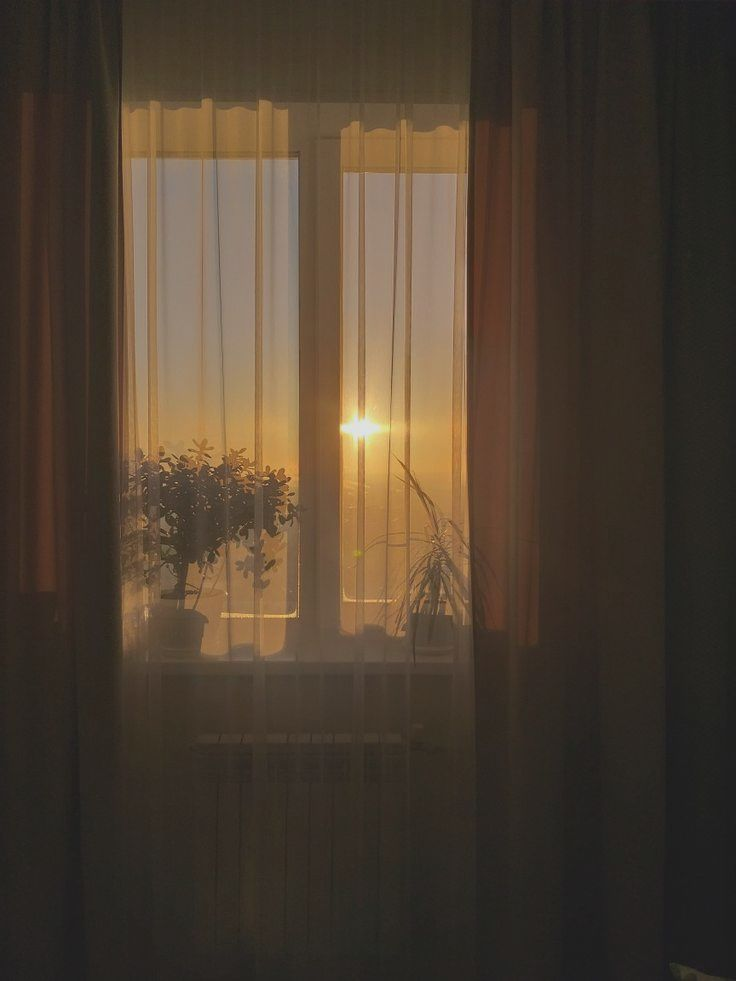

### Стало лучше видно комнату в деталях

## Растяжение динамического диапазона


Если интенсивности пикселей областей интереса находятся в узком динамическом диапазоне, то можно растянуть этот диапазон. Подобные преобразования выполняются согласно следующему выражению:

𝐼𝑛𝑒𝑤 = 256 * ((𝐼 − 𝐼𝑚𝑖𝑛)/(𝐼𝑚𝑎𝑥 − 𝐼𝑚𝑖𝑛 ))^𝛼 (1.1)

где 𝐼 и 𝐼𝑛𝑒𝑤 — массивы значений интенсивностей исходного и нового изображений соответственно; 𝐼𝑚𝑖𝑛 и 𝐼𝑚𝑎𝑥 — минимальное и максимальное значения интенсивностей исходного изображения соответственно; 𝛼 — коэффициент нелинейности.

Данное выражение является нелинейным из-за коэффициента 𝛼. В случае, если 𝛼 = 1, применение формулы (1.1) к исходному изображению не даст желаемого эффекта, поскольку гистограммы цветовых компонент изображения занимают весь возможный диапазон. Нелинейные преобразования проводятся для каждой цветовой составляющей.

In [62]:
def calc_nonlinear_stretching(image, alpha, Imin, Imax):
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x,i] = 255.0 * np.power((image[y,x,i] - Imin[i]) / (Imax[i] - Imin[i]), alpha)
    return image

In [63]:
alpha = 0.5 # Для примера взяли 0.5

# Вычисление максимальных и минимальных интенсивностей по каждому из каналов
Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
Imax = [np.max(image[:,:,i]) for i in range(image.shape[2])]
print(Imin)
print(Imax)

# Вычисление нелинейного преобразования интенсивностей и гистограммы
image_nonlinear_stretching = calc_nonlinear_stretching(np.array(image, dtype=np.float64), alpha, Imin, Imax)

image_nonlinear_stretching = np.round(image_nonlinear_stretching).astype(dtype=np.uint8)
hist_nonlinear_stretching = calc_hist(image_nonlinear_stretching)

[0, 0, 0]
[255, 255, 255]


(0.0, 256.0)

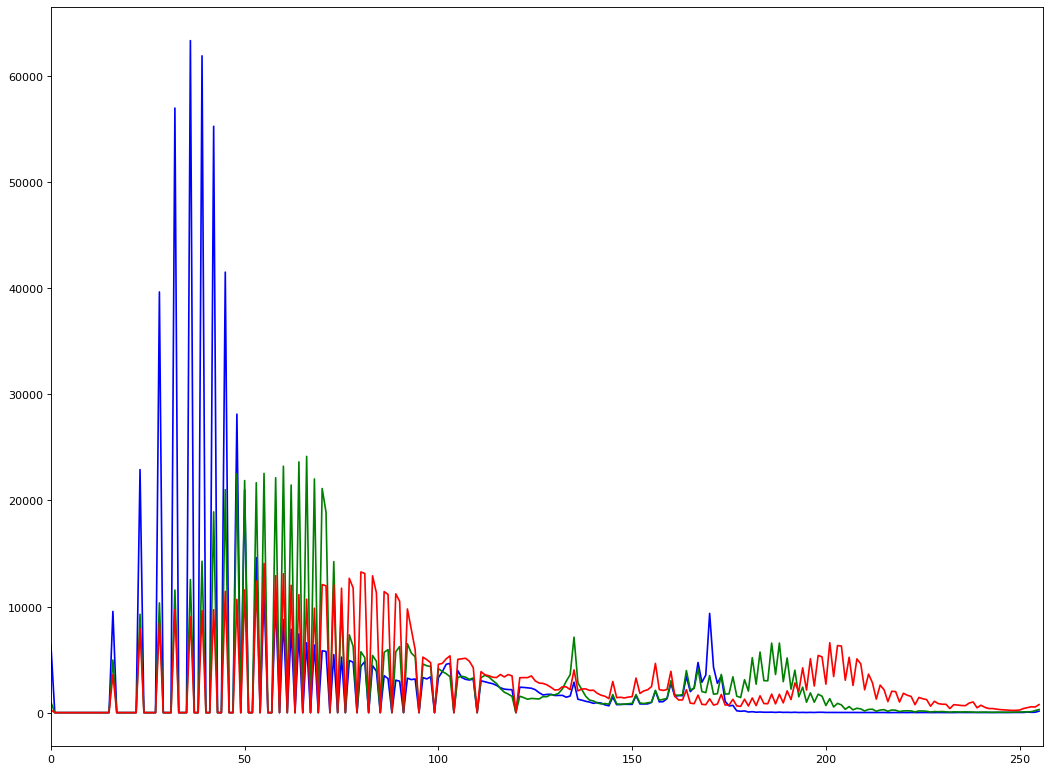

In [64]:
# Гистограмма после нелинейного преобразования интенсивностей
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    plt.plot(hist_nonlinear_stretching[i], color = col)
plt.xlim([0,256])

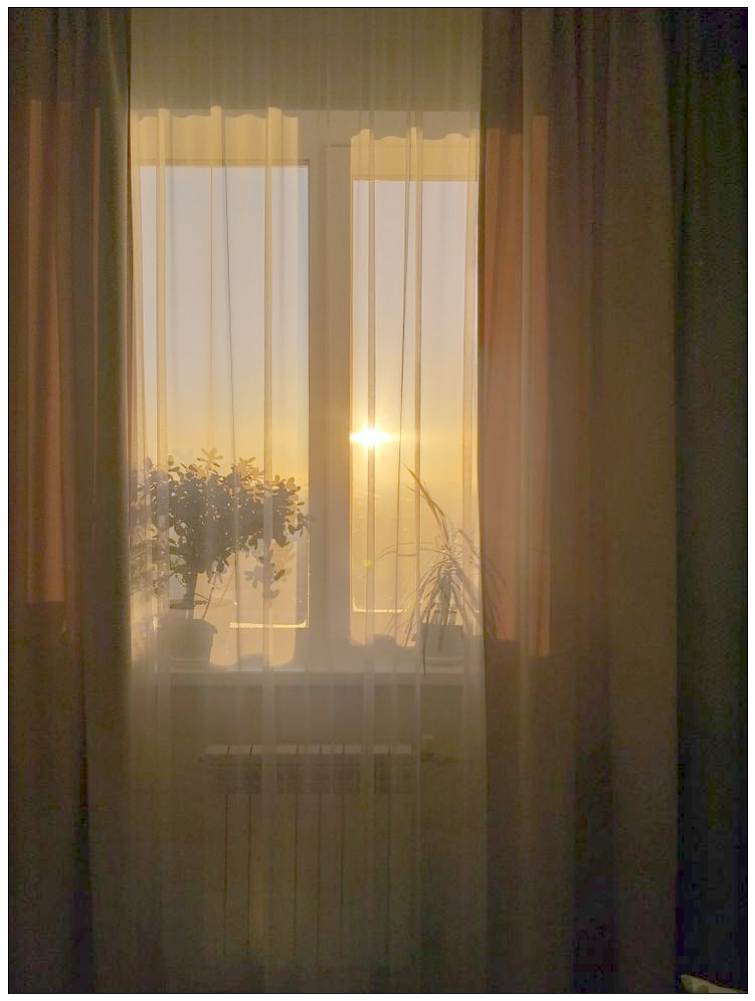

In [66]:
# Изображение после нелинейного преобразования интенсивностей
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image_nonlinear_stretching, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

Можно с уверенностью сказать, что изображение стало более различимым

## Равномерное преобразование

Осуществляется по следующей формуле:

𝐼𝑛𝑒𝑤 = (𝐼𝑚𝑎𝑥 − 𝐼𝑚𝑖𝑛) · 𝑃(𝐼) + 𝐼𝑚𝑖𝑛, (1.2)

где 𝐼𝑚𝑖𝑛, 𝐼𝑚𝑎𝑥 — минимальное и максимальное значения интенсивностей исходного изображения 𝐼; 𝑃(𝐼) — функция распределения вероятностей исходного изображения, которая аппроксимируется кумулятивной гистограммой:

In [67]:
# Вычисление кумулятивной гистограммы изображения без нормирования
def calc_cumulative_hist(image, maximum_intensity=256):
    hist = []
    for i in range(image.shape[2]):
        hist.append([0 for j in range(maximum_intensity)])
    hist = np.array(hist)
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                hist[i][image[y][x][i]] += 1
        for j in range(maximum_intensity - 1):
            hist[i][j + 1] += hist[i][j]
    return hist

# Применение равномерного преобразования
def apply_cumulative_hist(image, cumulative_hist):
    Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
    Imax = [np.max(image[:,:,i]) for i in range(image.shape[2])]
    image_new = np.zeros(image.shape, dtype="uint8")
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                Inew = (Imax[i] - Imin[i]) * cumulative_hist[i][image[y][x][i]] + Imin[i]
                if Inew < 0:
                    Inew = 0
                if Inew > 255:
                    Inew = 255
                image_new[y][x][i] = int(round(Inew))
    return image_new

In [68]:
image_cumulative_hist = calc_cumulative_hist(image)
image_cumulative_hist = image_cumulative_hist.astype(dtype=np.float64) / (image.shape[0] * image.shape[1])
image_uniform_transformation = apply_cumulative_hist(image, image_cumulative_hist)
hist_uniform_transformation = calc_hist(image_uniform_transformation)

(0.0, 256.0)

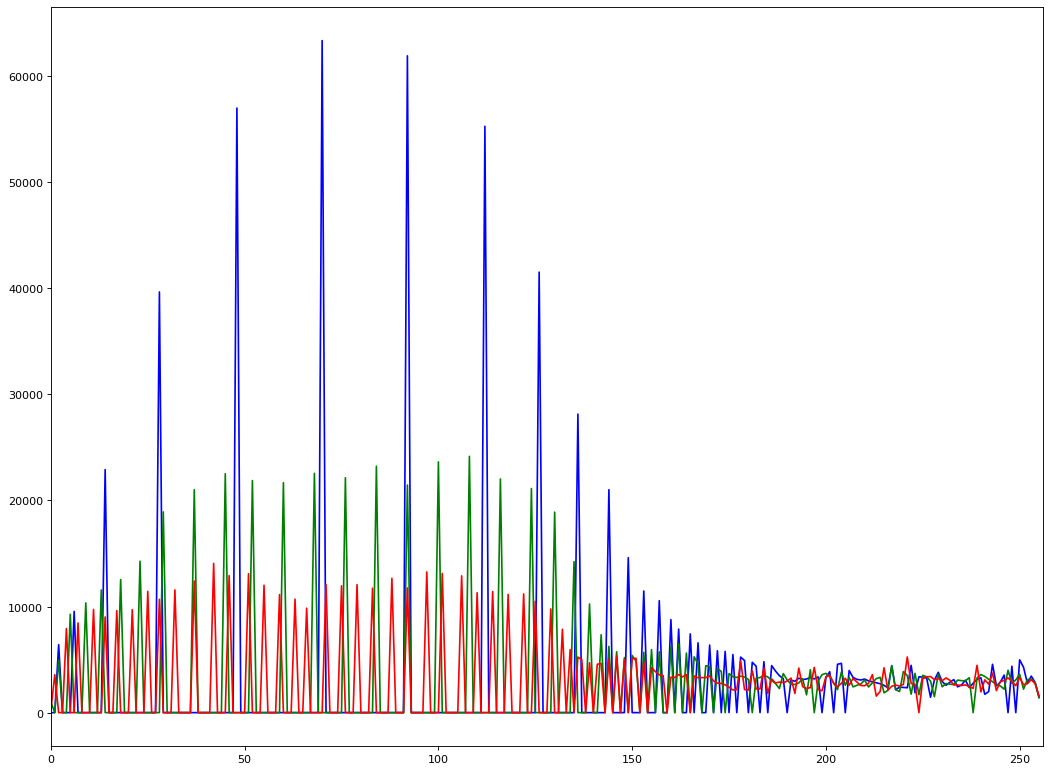

In [69]:
# Гистограмма после равномерного преобразования интенсивностей
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    plt.plot(hist_uniform_transformation[i], color = col)
plt.xlim([0,256])

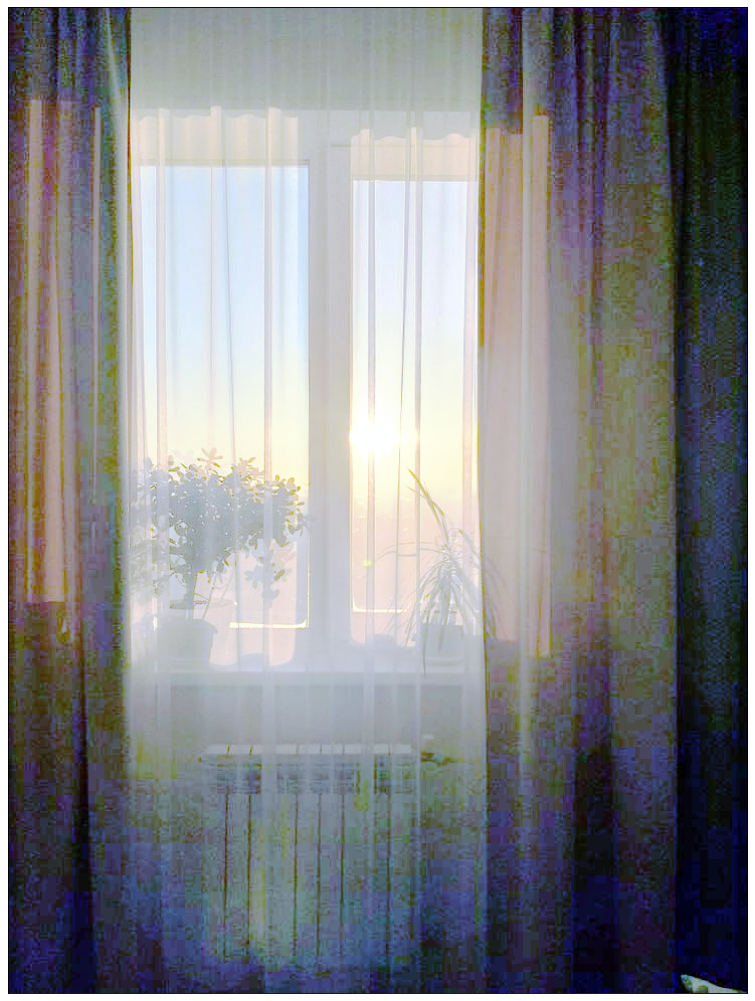

In [70]:
# Изображение после равномерного преобразования интенсивностей
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image_uniform_transformation, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

Стало хорошо видно детали комнаты, но появилось много шумов

## Экспоненциальное преобразование

Осуществляется по следующей формуле: 𝐼𝑛𝑒𝑤 = 𝐼𝑚𝑖𝑛 - 255 · (1 / 𝛼) · ln(1 − 𝑃(𝐼)), (1.4)

где 𝛼 — постоянная, характеризующая крутизну преобразования.

Согласно формуле (1.4) можно вычислить значения интенсивностей пикселей результирующего изображения.

In [101]:
# Применение экспоненциального преобразования
def apply_exponential_hist(image, cumulative_hist, alpha):
    Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
    image_new = np.zeros(image.shape, dtype="uint8")
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                try:
                  Inew = Imin[i] - 255.0 * (1 / alpha) * log(1 - cumulative_hist[i][image[y][x][i]])
                except:
                  Inew = 0
                if Inew < 0:
                    Inew = 0
                if Inew > 255:
                    Inew = 255
                image_new[y][x][i] = int(round(Inew))
    return image_new

In [102]:
image_cumulative_hist = calc_cumulative_hist(image)
image_cumulative_hist = image_cumulative_hist.astype(dtype=np.float64) / (image.shape[0] * image.shape[1])
image_exponential_transformation = apply_exponential_hist(image, image_cumulative_hist, alpha=1.5)
hist_exponential_transformation = calc_hist(image_exponential_transformation)

(0.0, 256.0)

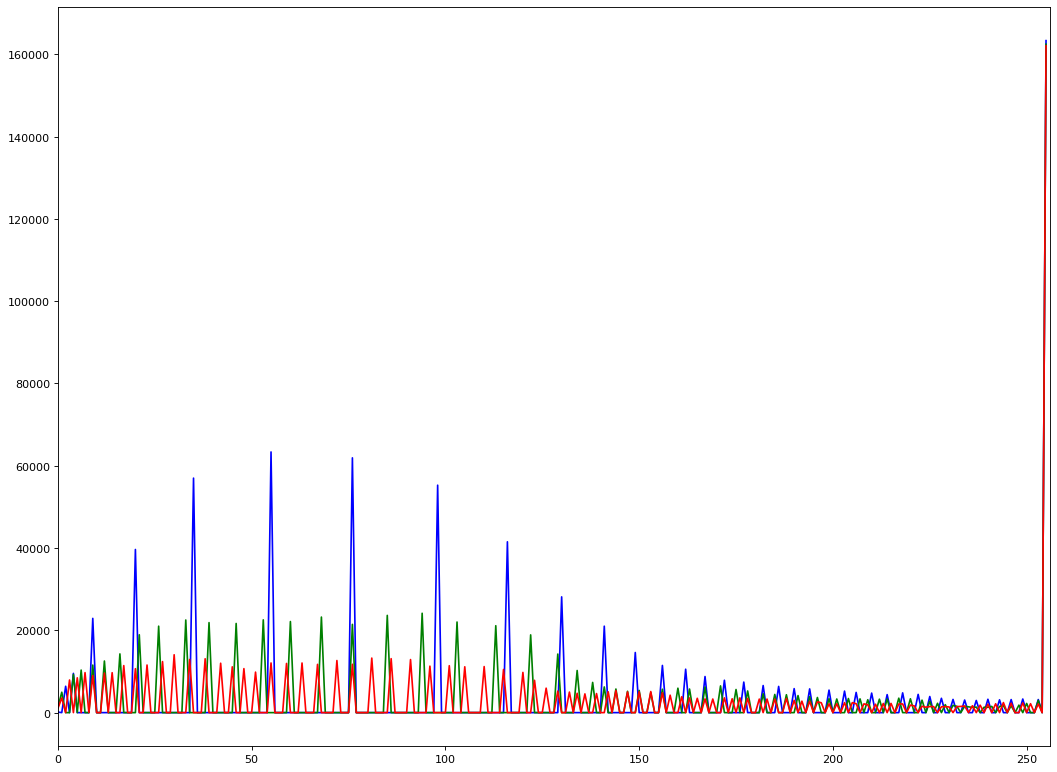

In [103]:
# Гистограмма после экспоненциального преобразования интенсивностей
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    plt.plot(hist_exponential_transformation[i], color = col)
plt.xlim([0,256])

In [ ]:
# Изображение после экспоненциального преобразования интенсивностей
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image_exponential_transformation, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

## Преобразование по закону Рэлея

Осуществляется по следующей формуле:

𝐼𝑛𝑒𝑤 = 𝐼𝑚𝑖𝑛 + 255 · (2*𝛼^2 * log(1 / (1 − 𝑃(𝐼)))) ^ (1/2),

где 𝛼 — постоянная, характеризующая гистограмму распределения интенсивностей элементов результирующего изображения.

In [105]:
# Применение преобразования Рэлея
def apply_Rayleigh_hist(image, cumulative_hist, alpha):
    Imin = [np.min(image[:,:,i]) for i in range(image.shape[2])]
    image_new = np.zeros(image.shape, dtype="uint8")
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                Inew = Imin[i] + 255.0 * pow((2 * pow(alpha, 2) * log(1 / (1 + 1e-9 - cumulative_hist[i][image[y][x][i]]))), 0.5)
                if Inew < 0:
                    Inew = 0
                if Inew > 255:
                    Inew = 255
                image_new[y][x][i] = int(round(Inew))
    return image_new

In [106]:
image_cumulative_hist = calc_cumulative_hist(image)
image_cumulative_hist = image_cumulative_hist.astype(dtype=np.float64) / (image.shape[0] * image.shape[1])
image_Rayleigh_transformation = apply_Rayleigh_hist(image, image_cumulative_hist, alpha=0.4)
hist_Rayleigh_transformation = calc_hist(image_Rayleigh_transformation)

(0.0, 256.0)

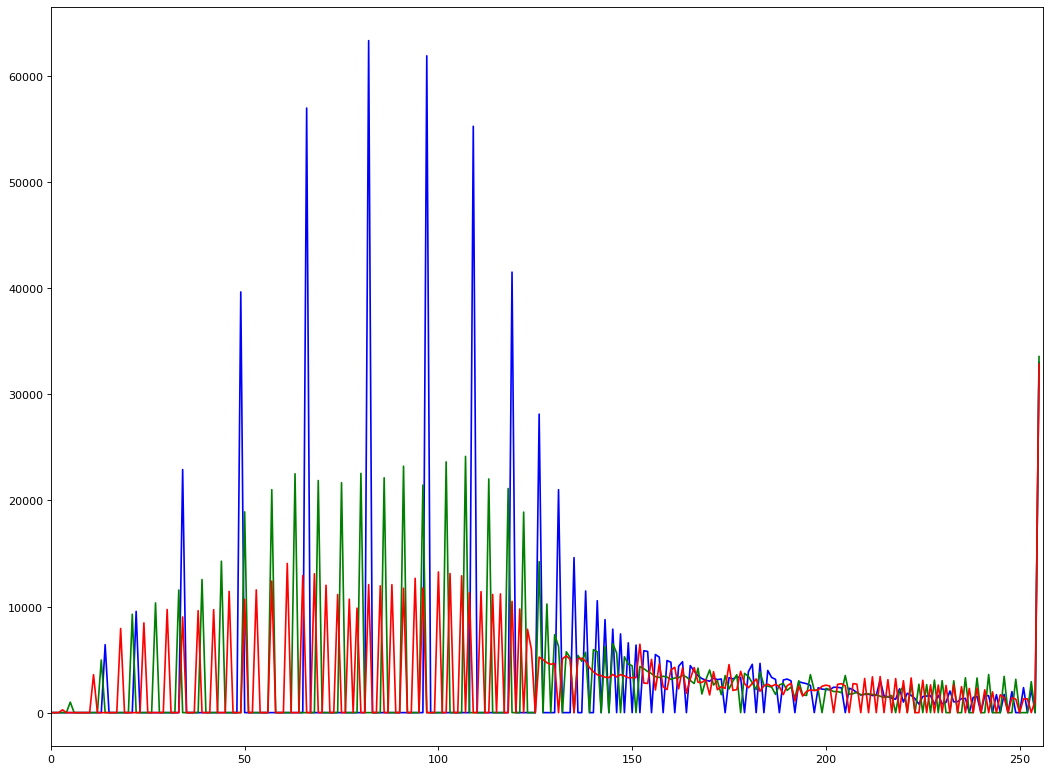

In [107]:
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    plt.plot(hist_Rayleigh_transformation[i], color = col)
plt.xlim([0,256])

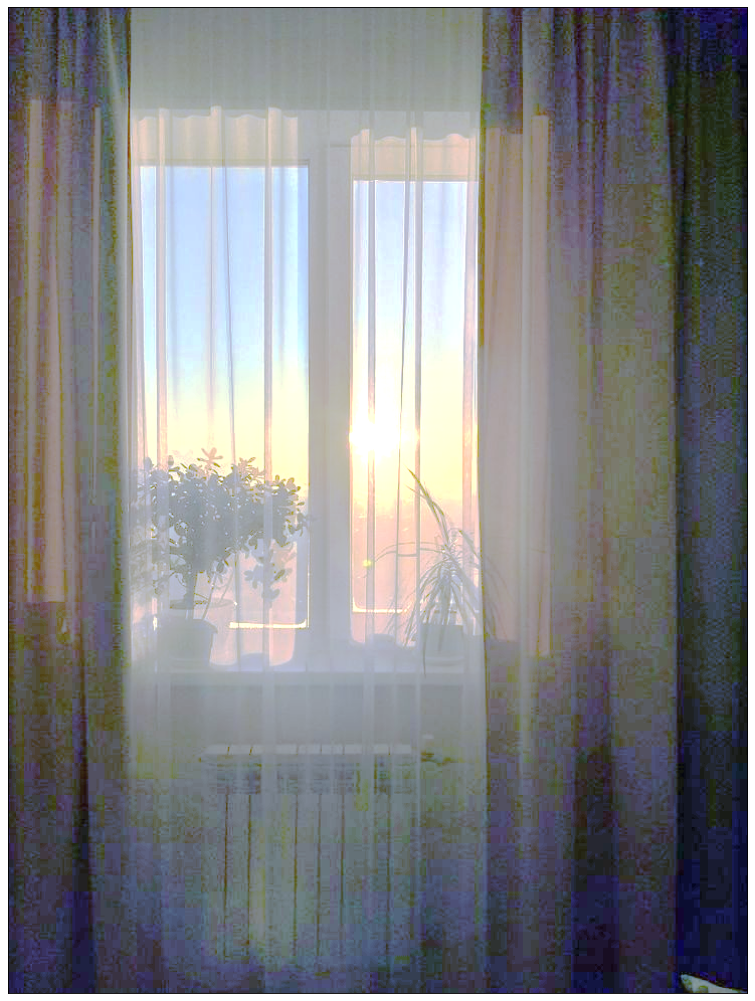

In [108]:
# Изображение после преобразования Рэлея
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image_Rayleigh_transformation, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

## Преобразование по закону степени 2/3

Осуществляется по следующей формуле:
𝐼𝑛𝑒𝑤 = 255 · (𝑃(𝐼)) ^ (2/3)

In [109]:
# Применение преобразования по закону степени 2/3
def apply_pow_2_3_hist(image, cumulative_hist):
    image_new = np.zeros(image.shape, dtype="uint8")
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                Inew = 255.0 * pow(cumulative_hist[i][image[y][x][i]], 2 / 3)
                if Inew < 0:
                    Inew = 0
                if Inew > 255:
                    Inew = 255
                image_new[y][x][i] = int(round(Inew))
    return image_new

In [110]:
image_cumulative_hist = calc_cumulative_hist(image)
image_cumulative_hist = image_cumulative_hist.astype(dtype=np.float64) / (image.shape[0] * image.shape[1])
image_pow_2_3_transformation = apply_pow_2_3_hist(image, image_cumulative_hist)
hist_pow_2_3_transformation = calc_hist(image_pow_2_3_transformation)

(0.0, 256.0)

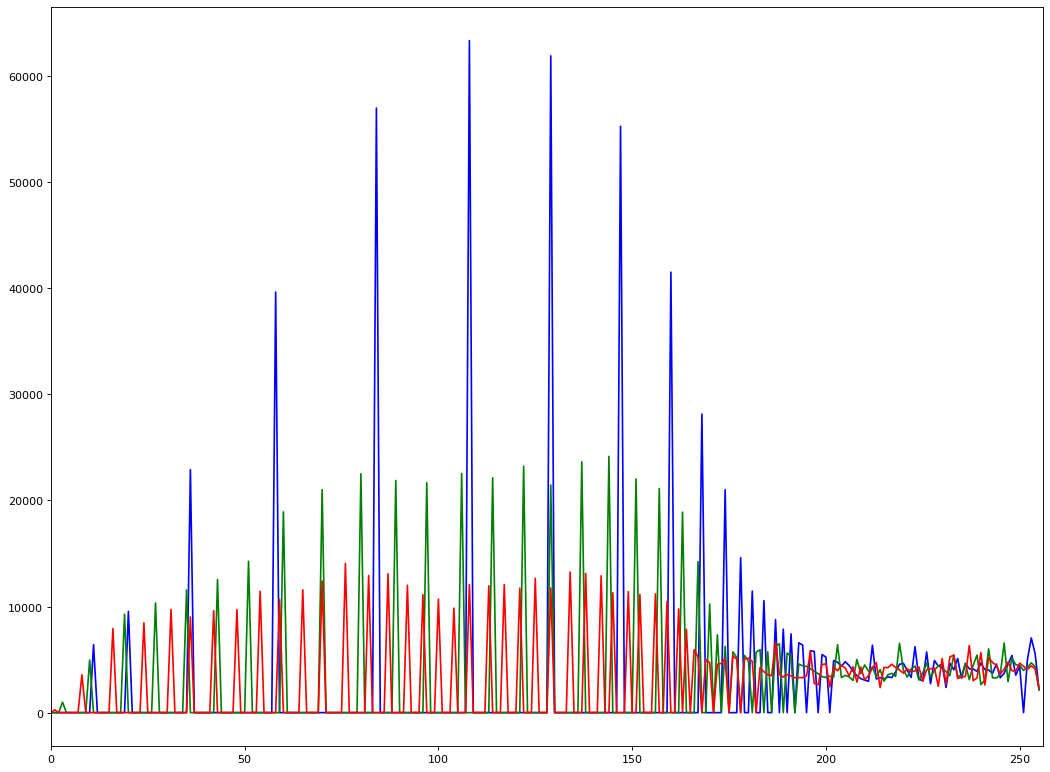

In [111]:
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    plt.plot(hist_pow_2_3_transformation[i], color = col)
plt.xlim([0,256])

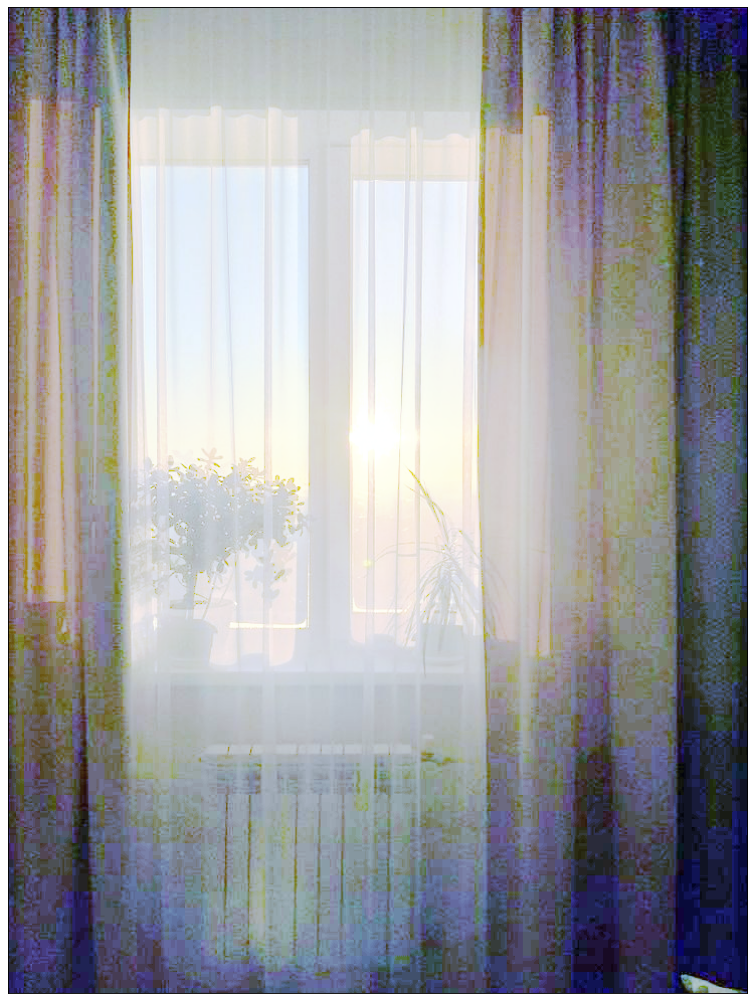

In [112]:
# Изображение после преобразования по закону степени 2/3
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image_pow_2_3_transformation, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

## Гиперболическое преобразование

Осуществляется по следующей формуле: 𝐼𝑛𝑒𝑤 = 255 * 𝛼 ^ (𝑃 (𝐼)),

где 𝛼 — постоянная, относительно которой осуществляется преобразование и, как правило, равная минимальному значению интенсивности элементов исходного изображения 𝛼 = 𝐼𝑚𝑖𝑛.

In [113]:
# Применение гиперболического преобразования
def apply_hyperbolic_hist(image, cumulative_hist, alpha_bias=0):
    alpha = [np.min(image[:,:,i]) for i in range(image.shape[2])]
    image_new = np.zeros(image.shape, dtype="uint8")
    for i in range(image.shape[2]):
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                Inew = 255.0 * pow(alpha[i] + alpha_bias, cumulative_hist[i][image[y][x][i]])
                if Inew < 0:
                    Inew = 0
                if Inew > 255:
                    Inew = 255
                image_new[y][x][i] = int(round(Inew))
    return image_new

In [115]:
image_cumulative_hist = calc_cumulative_hist(image)
image_cumulative_hist = image_cumulative_hist.astype(dtype=np.float64) / (image.shape[0] * image.shape[1])
image_hyperbolic_transformation = apply_hyperbolic_hist(image, image_cumulative_hist, alpha_bias=0.01)
hist_hyperbolic_transformation = calc_hist(image_hyperbolic_transformation)

(0.0, 256.0)

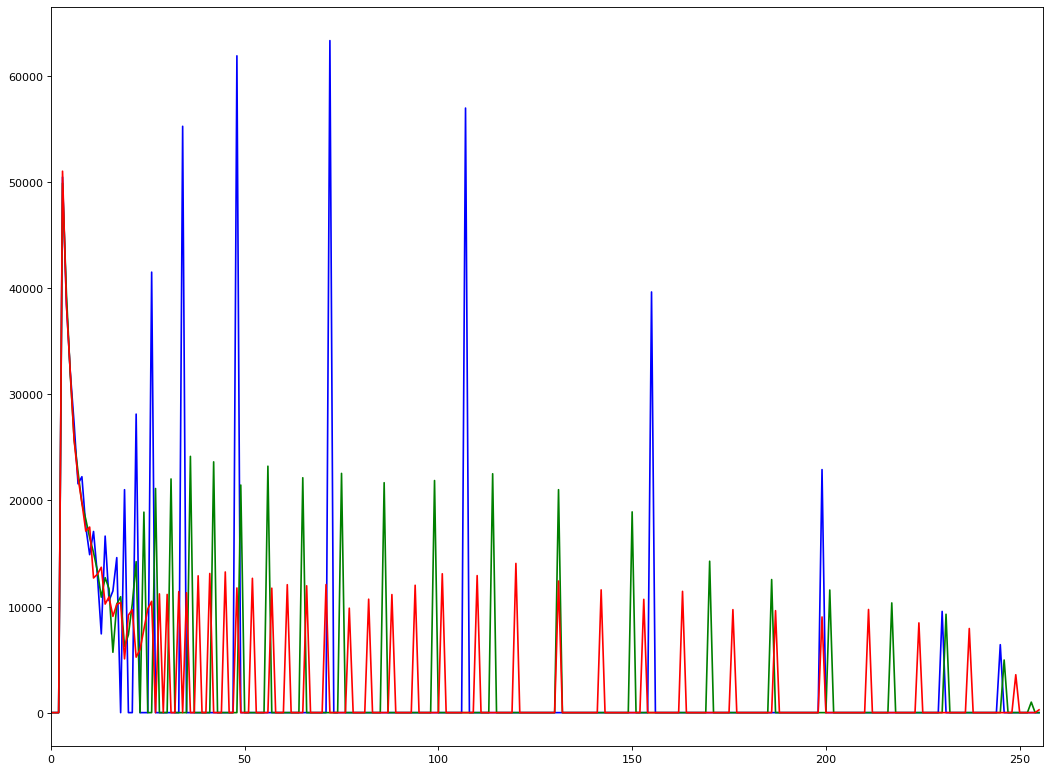

In [116]:
color = ('b','g','r')
figure(figsize=(16, 12), dpi=80)
for i, col in enumerate(color):
    plt.plot(hist_hyperbolic_transformation[i], color = col)
plt.xlim([0,256])

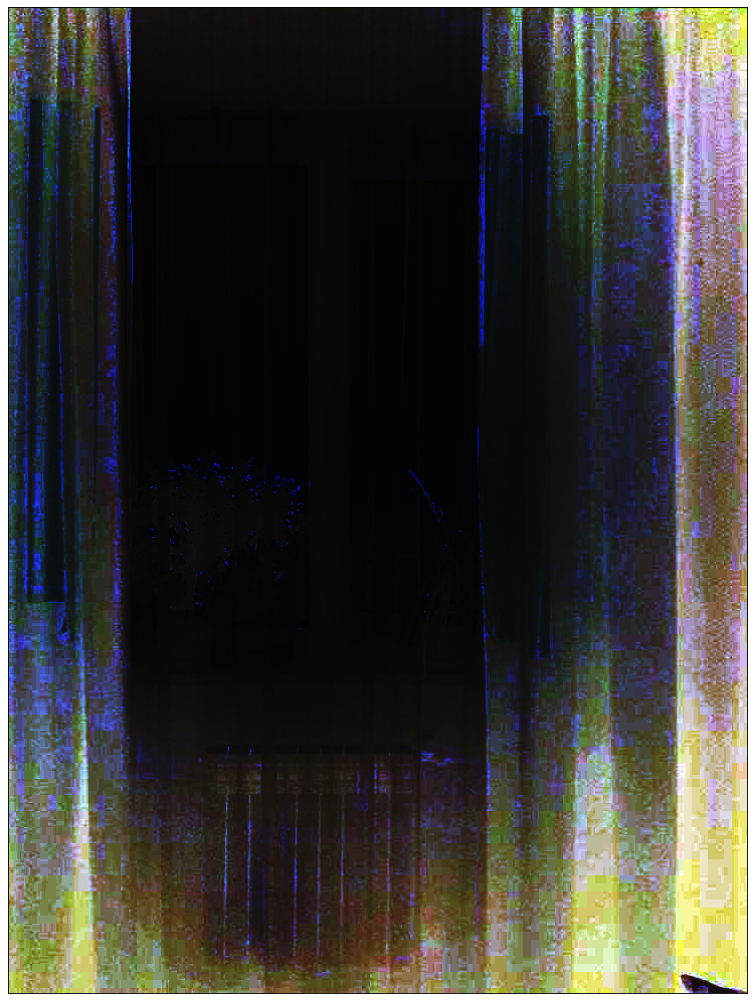

In [117]:
# Изображение после гиперболического преобразования
figure(figsize=(32, 16), dpi=80)
plt.imshow(cv2.cvtColor(image_hyperbolic_transformation, cv2.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

Чтобы не возводить 0 во всякие там степени было решено ввести дополнительное смещение нуля alpha_bias, чтобы увидеть хотя бы что-то на изображении. Преобразование может быть полезно для задач технического зрения, так как тут очётливо виден рельеф тёмных поверхностей.

Итог: нелинейное преобразование интенсивностей лучше всего себя показало